# Deep Learning project: Face Recognition

The following notebook is about training a face recognition model with deep learning methods. For this purpose, an own dataset with face images is to be created. With these images different models should be trained and finally compared. The project is part of the [Deep Learning](https://ilias.hs-heilbronn.de/ilias.php?ref_id=20660&cmdClass=ilrepositorygui&cmdNode=xo&baseClass=ilrepositorygui) course at the University of Heilbronn and serves educational purposes.

---

**Author:**

Dominik Bücher, Hochschuhle Heilbronn, Automotive System Engineering Master

dbuecher@stud.hs-heilbronn.de


**Professor**

Prof. Dr.-Ing. Nicolaj Stache 

nicolaj.stache@hs-heilbronn.de 

---



In [2]:
%pip install fast_ml
%pip install -U efficientnet
%pip install cv2

  Using cached fast_ml-3.68-py3-none-any.whl (42 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached efficientnet-1.1.1-py3-none-any.whl (18 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached lazy_loader-0.2-py3-none-any.whl (8.6 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached tifffile-2023.4.12-py3-none-any.whl (219 kB)
  Using cached PyWavelets-1.4.1-cp39-cp39-win_amd64.whl (4.2 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [3]:
# import the necessary packages
import os
import zipfile
# import matplotlib as plt
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf

# from pyimagesearch.resnet import ResNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
#from keras import optimizers
from tensorflow.keras import optimizers

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img
from matplotlib import pyplot
import efficientnet.keras as efn

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, ResNet101, InceptionV3

import PIL
import numpy as np
from keras.preprocessing import image
import pandas as pd
from PIL import Image
from PIL import Image, ImageOps




In [4]:
################ Unzip the dataset in the Colab runtime #################
zip_file_path = 'data/dataset.zip'
pathToZip = os.path.join(zip_file_path)
print("unzipping {}".format(pathToZip))

pathToData = "/tmp"
with zipfile.ZipFile(pathToZip, 'r') as zip_ref:
    zip_ref.extractall(pathToData)


# images
data_dominik    = glob.glob(os.path.join(pathToData, "dataset/Dominik/" + "*.jpeg"))
data_unknown    = glob.glob(os.path.join(pathToData, "dataset/Unknown/" + "*.jpg"))

print("Dominik : {} image paths".format(len(data_dominik)))
print("Unknown : {} image paths".format(len(data_unknown)))

unzipping data/dataset.zip
Dominik : 500 image paths
Unknown : 300 image paths


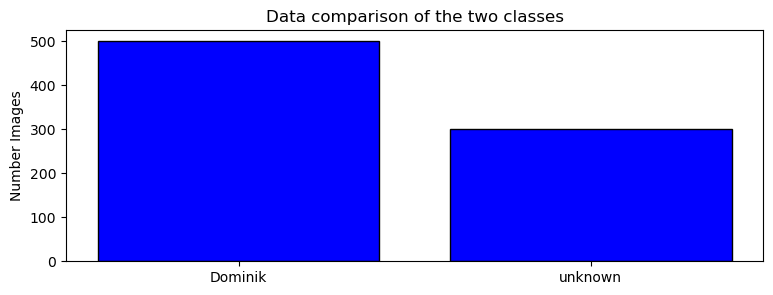

In [5]:
names = ['Dominik', 'unknown']
values = [len(data_dominik), len(data_unknown)]

plt.figure(figsize=(9, 3))
plt.bar(names, values, color='blue',edgecolor='black')
plt.ylabel('Number Images')
plt.title('Data comparison of the two classes')
plt.show()

In [6]:
images_dominik = []
for filename in glob.glob("/tmp/dataset/Dominik/" + "*.jpeg"): #assuming gif
    im=Image.open(filename)
    im = ImageOps.exif_transpose(im)
    images_dominik.append(im.resize([224,224]))

print("list: ", len(images_dominik))
print(images_dominik[0])


images_unknown = []
for filename in glob.glob("/tmp/dataset/Unknown/" + "*.jpg"): #assuming gif
    im=Image.open(filename)
    im = ImageOps.exif_transpose(im)
    images_unknown.append(im.resize([224,224]))

print("list: ", len(images_unknown))
print(images_unknown[0])


list:  500
<PIL.Image.Image image mode=RGB size=224x224 at 0x12885B96FD0>
list:  300
<PIL.Image.Image image mode=RGB size=224x224 at 0x128862B51C0>


In [7]:
images_dominik_norm = []
for i in range(len(images_dominik)):
        temp_data = img_to_array(images_dominik[i])
        img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images_dominik_norm.append(array_to_img(img_norm))


images_unknown_norm = []
for i in range(len(images_unknown)):
        temp_data = img_to_array(images_unknown[i])
        img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images_unknown_norm.append(array_to_img(img_norm))

In [8]:
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
y_unknown = []
for i in range(len(images_unknown_norm)):
    y_unknown.append('unknown')

y_dominik = []
for i in range(len(images_dominik_norm)):
    y_dominik.append('Dominik')

# In the first step we will split the data in training and remaining dataset
X_train_unknown, X_rem_unknown, y_train_unknown, y_rem_unknown = train_test_split(images_unknown_norm,y_unknown, train_size=0.7)
X_train_dominik, X_rem_dominik, y_train_dominik, y_rem_dominik = train_test_split(images_dominik_norm,y_dominik, train_size=0.7)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid_unknown, X_test_unknown, y_valid_unknown, y_test_unknown = train_test_split(X_rem_unknown,y_rem_unknown, test_size=0.3)
X_valid_dominik, X_test_dominik, y_valid__dominik, y_test__dominik = train_test_split(X_rem_dominik,y_rem_dominik, test_size=0.3)

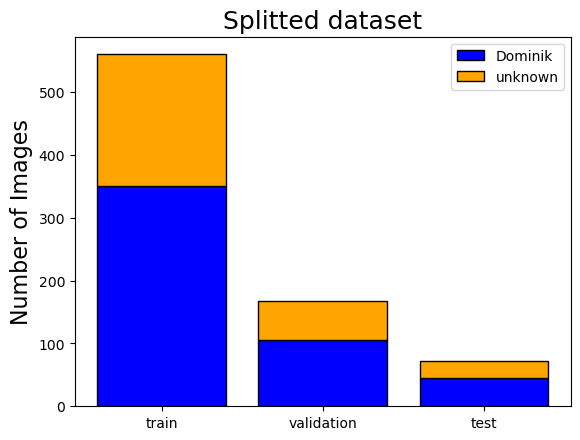

In [9]:
split=['train', 'validation', 'test']
data_origin=['Dominik','unknown']
pos = np.arange(len(split))
vales_dominik = [len(X_train_dominik), len(X_valid_dominik), len(X_test_dominik)]
values_unknown = [len(X_train_unknown), len(X_valid_unknown), len(X_test_unknown)]

plt.bar(pos,vales_dominik,color='blue',edgecolor='black')
plt.bar(pos,values_unknown,color='orange',edgecolor='black',bottom=vales_dominik)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Splitted dataset',fontsize=18)
plt.legend(data_origin)
plt.show()

In [10]:
for i in range(len(X_train_unknown)):
    X_train_unknown[i].save(r'data\train\unknown\image_' +str(i) +'.jpg', 'JPEG')
for i in range(len(X_valid_unknown)):
    X_valid_unknown[i].save(r'data\validation\unknown\image_' +str(i) +'.jpg', 'JPEG')
for i in range(len(X_test_unknown)):
    X_test_unknown[i].save(r'data\test\unknown\image_' +str(i) +'.jpg', 'JPEG')

In [11]:
for i in range(len(X_train_dominik)):
    X_train_dominik[i].save(r'data\train\Dominik\image_' +str(i) +'.jpg', 'JPEG')
for i in range(len(X_valid_dominik)):
    X_valid_dominik[i].save(r'data\validation\Dominik\image_' +str(i) +'.jpg', 'JPEG')
for i in range(len(X_test_dominik)):
    X_test_dominik[i].save(r'data\test\Dominik\image_' +str(i) +'.jpg', 'JPEG')

In [12]:
train_unknown_array = []
for i in range(len(X_train_unknown)):
    train_unknown_array.append(np.expand_dims(img_to_array(X_train_unknown[i]),axis=0))

valid_unknown_array = []
for i in range(len(X_valid_unknown)):
    valid_unknown_array.append(np.expand_dims(img_to_array(X_valid_unknown[i]), axis=0))

train_dominik_array = []
for i in range(len(X_train_dominik)):
    train_dominik_array.append(np.expand_dims(img_to_array(X_train_dominik[i]), axis=0))

valid_dominik_array = []
for i in range(len(X_valid_dominik)):
    valid_dominik_array.append(np.expand_dims(img_to_array(X_valid_dominik[i]), axis=0))

In [13]:
train_unknown_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True ,rotation_range=30, brightness_range=[0.4,1.2], zoom_range=[0.6,1.0], fill_mode='reflect')
validation_unknown_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True ,rotation_range=30, brightness_range=[0.4,1.2], zoom_range=[0.6,1.0], fill_mode='reflect')
train_dominik_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True ,rotation_range=30, brightness_range=[0.4,1.2], zoom_range=[0.6,1.0], fill_mode='reflect')
validation_dominik_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True ,rotation_range=30, brightness_range=[0.4,1.2], zoom_range=[0.6,1.0], fill_mode='reflect')


for i in range(len(train_unknown_array)):
    train_generator_unknown = train_unknown_datagen.flow(train_unknown_array[i], batch_size = 1)
    # generate batch of images
    batch = train_generator_unknown.next()
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm) 
    im.save(r'data\train\unknown\augmented_image_'+ str(i)+ '.jpg')

for i in range(len(valid_unknown_array)):
    valid_generator_unknown = validation_unknown_datagen.flow(valid_unknown_array[i], batch_size = 1)
    # generate batch of images
    batch = valid_generator_unknown.next()
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm) 
    im.save(r'data\validation\unknown\augmented_image_'+ str(i)+ '.jpg')

for i in range(len(train_dominik_array)):
    train_generator_dominik = train_dominik_datagen.flow(train_dominik_array[i], batch_size = 1)
    # generate batch of images
    batch = train_generator_dominik.next()
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm) 
    im.save(r'data\train\Dominik\augmented_image_'+ str(i)+ '.jpg')

for i in range(len(valid_dominik_array)):
    valid_generator_dominik = validation_dominik_datagen.flow(valid_dominik_array[i], batch_size = 1)
    # generate batch of images
    batch = valid_generator_dominik.next()
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm) 
    im.save(r'data\validation\Dominik\augmented_image_'+ str(i)+ '.jpg')

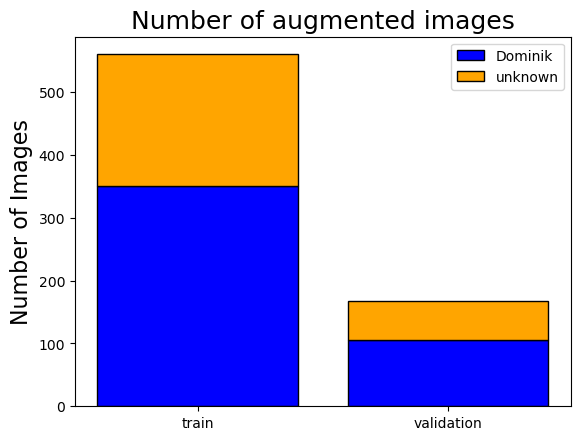

In [14]:
split=['train', 'validation']
data_origin=['Dominik','unknown']
pos = np.arange(len(split))
vales_train = [len(train_dominik_array), len(valid_dominik_array)]
values_valid = [len(train_unknown_array), len(valid_unknown_array)]

plt.bar(pos,vales_train,color='blue',edgecolor='black')
plt.bar(pos,values_valid,color='orange',edgecolor='black',bottom=vales_train)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Number of augmented images',fontsize=18)
plt.legend(data_origin)
plt.show()

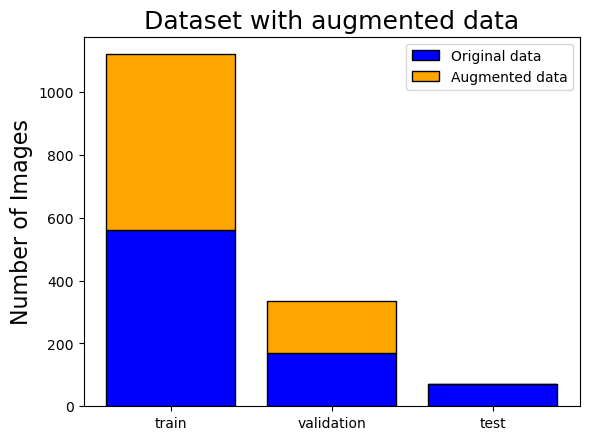

In [15]:
split=['train', 'validation', 'test']
data_origin=['Original data','Augmented data']
pos = np.arange(len(split))
vales_og = [len(train_dominik_array+train_unknown_array), len(valid_dominik_array+valid_unknown_array), len(X_test_unknown+X_test_dominik)]
values_augmented = [len(train_dominik_array+train_unknown_array), len(valid_dominik_array+valid_unknown_array), 0]

plt.bar(pos,vales_og,color='blue',edgecolor='black')
plt.bar(pos,values_augmented,color='orange',edgecolor='black',bottom=vales_og)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Dataset with augmented data',fontsize=18)
plt.legend(data_origin)
plt.show()

In [16]:
# Bild-Daten-Generator für Data Augmentation
train_datagen = ImageDataGenerator(
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

validation_datagen = ImageDataGenerator()

In [17]:
# Daten-Generatoren für Trainings- und Validierungsdaten erstellen
batch_size = 16
train_dir = "data/train/"
val_dir = "data/validation/"
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1120 images belonging to 2 classes.
Found 336 images belonging to 2 classes.


**Models**

In [18]:
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Again, let us freeze the layers:
for layer in ResNet50_base_model.layers:
    layer.trainable = False
    
# Füge einen Klassifikationskopf hinzu
ResNet50_model = tf.keras.Sequential([
    ResNet50_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [19]:
# Erstelle das ResNet101-Modell
ResNet101_base_model = ResNet101(include_top=False, input_shape=(224, 224, 3))
# Again, let us freeze the layers:
for layer in ResNet101_base_model.layers:
    layer.trainable = False
    
# Füge einen Klassifikationskopf hinzu
ResNet101_model = tf.keras.Sequential([
    ResNet101_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

171450368/171446536 [==============================] - 30s 0us/step


In [20]:
# Erstelle das EfficientNetB0-Modell
EfficientNetB0_base_model = efn.EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights = 'imagenet')
# Again, let us freeze the layers:
for layer in EfficientNetB0_base_model.layers:
    layer.trainable = False

# Füge einen Klassifikationskopf hinzu
EfficientNetB0_model = tf.keras.Sequential([
    EfficientNetB0_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [21]:
# Erstelle das VGG16-Modell
VGG16_base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
# Again, let us freeze the layers:
for layer in VGG16_base_model.layers:
    layer.trainable = False
    
# Füge einen Klassifikationskopf hinzu
VGG16_model = tf.keras.Sequential([
    VGG16_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

58892288/58889256 [==============================] - 11s 0us/step


In [22]:
# Erstelle das InceptionNetV3-Modell
InceptionV3_base_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
# Again, let us freeze the layers:
for layer in InceptionV3_base_model.layers:
    layer.trainable = False

# Füge einen Klassifikationskopf hinzu
InceptionV3_model = tf.keras.Sequential([
    InceptionV3_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


87916544/87910968 [==============================] - 18s 0us/step


In [23]:
# Modell kompilieren
VGG16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ResNet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ResNet101_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
EfficientNetB0_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Modell trainieren
total_val = 2*len(valid_dominik_array+valid_unknown_array)
epochs = 10
steps_per_epoch = 20
print('VGG16:')
history_VGG16 = VGG16_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=total_val // batch_size)
print('ResNet50:')
history_ResNet50 = ResNet50_model.fit(train_generator, epochs=epochs, steps_per_epoch= steps_per_epoch, validation_data=validation_generator, validation_steps=total_val // batch_size)
print('ResNet101:')
history_ResNet101 = ResNet101_model.fit(train_generator, epochs=epochs, steps_per_epoch= steps_per_epoch, validation_data=validation_generator, validation_steps=total_val // batch_size)
print('EfficientNetB0:')
history_EfficientNetB0 = EfficientNetB0_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=total_val // batch_size)
print('InceptionV3:')
history_InceptionV3 = InceptionV3_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=total_val // batch_size)


VGG16:
Epoch 1/10
20/20 [==============================] - 24s 1s/step - loss: 0.8535 - accuracy: 0.7594 - val_loss: 0.4171 - val_accuracy: 0.8571
Epoch 2/10
20/20 [==============================] - 26s 1s/step - loss: 0.3248 - accuracy: 0.8969 - val_loss: 0.2170 - val_accuracy: 0.9315
Epoch 3/10
20/20 [==============================] - 26s 1s/step - loss: 0.1796 - accuracy: 0.9344 - val_loss: 0.1697 - val_accuracy: 0.9405
Epoch 4/10
20/20 [==============================] - 26s 1s/step - loss: 0.0955 - accuracy: 0.9531 - val_loss: 0.1415 - val_accuracy: 0.9583
Epoch 5/10
20/20 [==============================] - 26s 1s/step - loss: 0.0858 - accuracy: 0.9750 - val_loss: 0.1208 - val_accuracy: 0.9613
Epoch 6/10
20/20 [==============================] - 27s 1s/step - loss: 0.0336 - accuracy: 0.9906 - val_loss: 0.1023 - val_accuracy: 0.9732
Epoch 7/10
20/20 [==============================] - 27s 1s/step - loss: 0.0406 - accuracy: 0.9844 - val_loss: 0.1009 - val_accuracy: 0.9673
Epoch 8/10
20

In [26]:
# # Speichere die Gewichte des trainierten Modells
# VGG16_model.save_weights('models/VGG16_model_weights.h5')
# ResNet50_model.save_weights('models/ResNet50_model_weights.h5')
# ResNet101_model.save_weights('models/ResNet101_model_weights.h5')
# EfficientNetB0_model.save_weights('models/EfficientNetB0_model_weights.h5')
# InceptionV3_model.save_weights('models/InceptionV3_model_weights.h5')

# Speichere das gesamte trainierte Modell
VGG16_model.save('models/VGG16_model.h5')
ResNet50_model.save('models/ResNet50_model.h5')
ResNet101_model.save('models/ResNet101_model.h5')
EfficientNetB0_model.save('models/EfficientNetB0_model.h5')
InceptionV3_model.save('models/InceptionV3_model.h5')


# # Speichere das gesamte trainierte Modell
# VGG16_model.save('models/VGG16_model.h')
# ResNet50_model.save('models/ResNet50_model.h')
# ResNet101_model.save('models/ResNet101_model.h')
# EfficientNetB0_model.save('models/EfficientNetB0_model.h')
# InceptionV3_model.save('models/InceptionV3_model.h')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


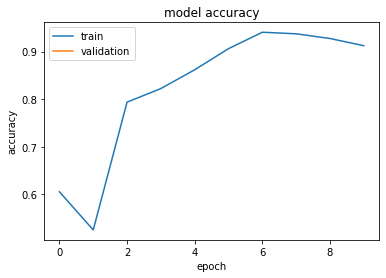

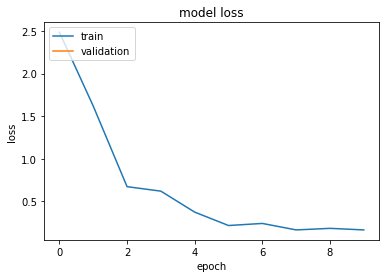

In [23]:
# Plot training & validation accuracy values of VGG16
print(history_VGG16.history.keys())
#  "Accuracy"
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


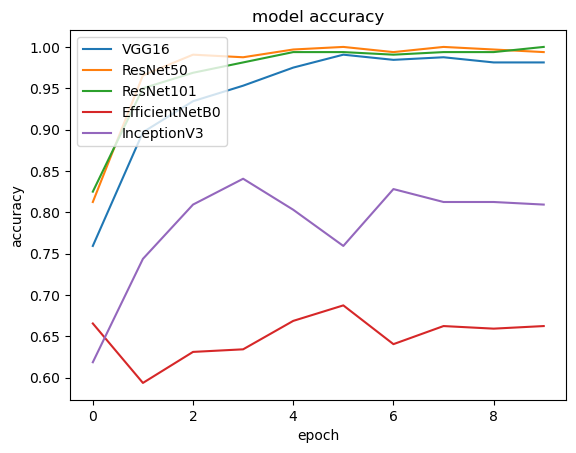

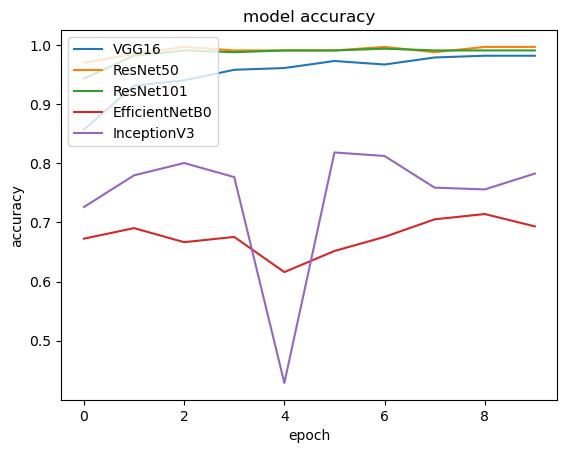

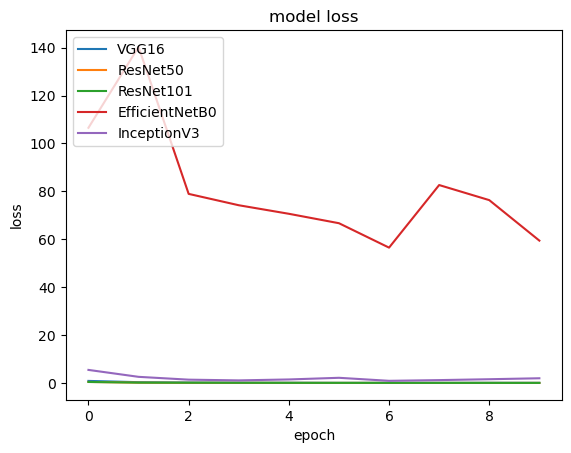

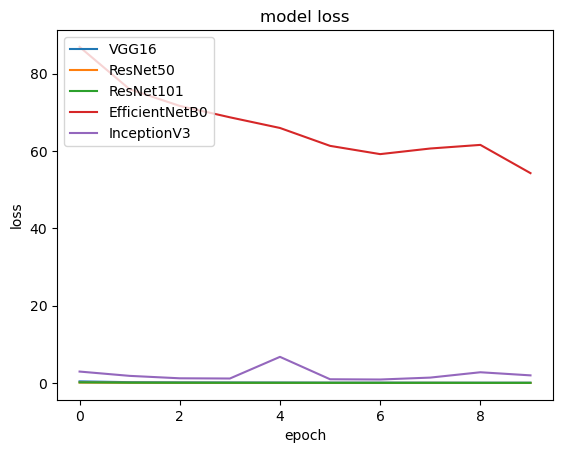

In [27]:
# Plot training & validation accuracy values of VGG16
print(history_VGG16.history.keys())
#  "Accuracy"
plt.plot(history_VGG16.history['accuracy'], label = "VGG16")
plt.plot(history_ResNet50.history['accuracy'], label = "ResNet50")
plt.plot(history_ResNet101.history['accuracy'], label = "ResNet101")
plt.plot(history_EfficientNetB0.history['accuracy'], label = "EfficientNetB0")
plt.plot(history_InceptionV3.history['accuracy'], label = "InceptionV3")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'InceptionV3'], loc='upper left')
plt.show()

#  "val_accuracy"
plt.plot(history_VGG16.history['val_accuracy'], label = "VGG16")
plt.plot(history_ResNet50.history['val_accuracy'], label = "ResNet50")
plt.plot(history_ResNet101.history['val_accuracy'], label = "ResNet101")
plt.plot(history_EfficientNetB0.history['val_accuracy'], label = "EfficientNetB0")
plt.plot(history_InceptionV3.history['val_accuracy'], label = "InceptionV3")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'InceptionV3'], loc='upper left')
plt.show()


# "Loss"
plt.plot(history_VGG16.history['loss'], label = "VGG16")
plt.plot(history_ResNet50.history['loss'], label = "ResNet50")
plt.plot(history_ResNet101.history['loss'], label = "ResNet101")
plt.plot(history_EfficientNetB0.history['loss'], label = "EfficientNetB0")
plt.plot(history_InceptionV3.history['loss'], label = "InceptionV3")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'InceptionV3'], loc='upper left')
plt.show()

# "val_loss"
plt.plot(history_VGG16.history['val_loss'], label = "VGG16")
plt.plot(history_ResNet50.history['val_loss'], label = "ResNet50")
plt.plot(history_ResNet101.history['val_loss'], label = "ResNet101")
plt.plot(history_EfficientNetB0.history['val_loss'], label = "EfficientNetB0")
plt.plot(history_InceptionV3.history['val_loss'], label = "InceptionV3")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'InceptionV3'], loc='upper left')
plt.show()

In [ ]:

# Trainiere das Modell
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=num_valid // batch_size
)

# Zeige den Verlauf des Trainings an
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modellgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend(['Training', 'Validierung'], loc='upper left')
plt.show()

# Speichere die Gewichte des trainierten Modells
model.save_weights('trained_model_weights.h5')

# Speichere das gesamte trainierte Modell
model.save('trained_model.h

In [ ]:
images_dominik_norm = []
for i in range(len(images_dominik)):
        temp_data = img_to_array(images_dominik[i])
        img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images_dominik_norm.append(array_to_img(img_norm))

In [31]:
import numpy as np
from PIL import Image
from keras.models import load_model

# Laden des .h5-Modells
model_path = 'models/ResNet50_model.h5'
model = load_model(model_path)

# Laden und Vorbereiten der Testbilder
test_path_dominik = 'data/test/Dominik'
test_path_unknown = 'data/test/unknown'

def getImages(test_image_folder):
    test_images = []
    for image_path in os.listdir(test_image_folder):
        image = Image.open(os.path.join(test_image_folder, image_path))
        temp_data = img_to_array(image)
        img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        image_norm = array_to_img(img_norm)

        image = image_norm.resize((224, 224))  # Passe die Bildgröße an deine Anforderungen an
        image = np.array(image)# / 255.0  # Normalisiere die Bildpixel auf den Bereich 0-1
        test_images.append(image)

    # Konvertiere die Liste der Bilder in ein Numpy-Array
    test_images = np.array(test_images)
    return test_images

test_images_dominik = getImages(test_path_dominik)
test_images_unknown = getImages(test_path_unknown)
# Anwenden des Modells auf den Testdatensatz
predictions_dominik = model.predict(test_images_dominik)
predictions_unknown = model.predict(test_images_unknown)

# Hier kannst du weitere Schritte zur Bewertung der Vorhersagen durchführen, basierend auf deinem Anwendungsfall




In [32]:
print('predictions_dominik: ')
print(predictions_dominik)
print('#########################################')
print('predictions_unknown: ')
print(predictions_unknown)

predictions_dominik: 
[[9.9897766e-01 1.0223336e-03]
 [9.9822778e-01 1.7721965e-03]
 [9.9781835e-01 2.1816178e-03]
 [9.9954331e-01 4.5670909e-04]
 [9.9878615e-01 1.2138799e-03]
 [9.9501318e-01 4.9867770e-03]
 [9.9371380e-01 6.2862528e-03]
 [9.9881101e-01 1.1889730e-03]
 [9.9979383e-01 2.0613412e-04]
 [9.9337417e-01 6.6258041e-03]
 [9.9924624e-01 7.5384520e-04]
 [9.9769574e-01 2.3042590e-03]
 [9.9829286e-01 1.7071001e-03]
 [9.9984121e-01 1.5880739e-04]
 [9.9923456e-01 7.6545565e-04]
 [9.9971765e-01 2.8235154e-04]
 [9.9803180e-01 1.9682299e-03]
 [9.9483359e-01 5.1663825e-03]
 [9.9984121e-01 1.5880739e-04]
 [9.9992001e-01 7.9935860e-05]
 [9.9978739e-01 2.1268244e-04]
 [9.9298346e-01 7.0165712e-03]
 [9.9699968e-01 3.0002436e-03]
 [9.9418008e-01 5.8199656e-03]
 [9.9645066e-01 3.5492829e-03]
 [9.9930465e-01 6.9537823e-04]
 [9.9909461e-01 9.0543972e-04]
 [9.9744570e-01 2.5543240e-03]
 [9.9736100e-01 2.6389505e-03]
 [9.9936789e-01 6.3212210e-04]
 [9.9949193e-01 5.0803757e-04]
 [9.9981433e-01 1